## Compare learning trajectories on LLaMa 7b, 13b, and 70b
### Generate 3D animations of InPCA embedding

In [180]:

import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) / 'processed_series'
# processed_series_path = Path(parent_dir) / '..' / 'llmICL' / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

print(sys.path)
from ICL import MultiResolutionPDF

def average_PDF_list(PDF_list, avg_interval = 6):
    """
    rolling average over a list of hierarchy PDFs
    """
    PDF_list_averaged = []
    common_bin_center_arr = PDF_list[0].bin_center_arr
    common_bin_width_arr = PDF_list[0].bin_width_arr
    for i in range(len(PDF_list)-avg_interval):
        avg_bin_height_arr = np.average([PDF_list[i+x].bin_height_arr for x in range(avg_interval)], axis = 0)
        avg_PDF = MultiResolutionPDF()
        avg_PDF.add_bin(common_bin_center_arr, common_bin_width_arr, avg_bin_height_arr)
        PDF_list_averaged += [avg_PDF]
    return PDF_list_averaged
        
def gaussian_manifold_generator(PDF_list, sigma_list, mean_list):
    """
        PDF_list: example PDF
    """
    assert len(sigma_list) == len(mean_list), "Sigma list and mean list must be of the same length"
    PDF_manifold_list = copy.deepcopy(PDF_list[:len(sigma_list)])
    for i, (sigma, mean) in enumerate(zip(sigma_list, mean_list)):
        def cdf(x):
            return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
        PDF_manifold_list[i].discretize(cdf, mode = 'cdf')
        
    return PDF_manifold_list
    
def temperature_manifold_generator(true_PDF, temperature_list):
    PDF_manifold_list = [copy.deepcopy(true_PDF) for _ in temperature_list]
    for i, alpha in enumerate(temperature_list):
        # PDF_manifold_list[i].bin_height_arr += 0.01
        PDF_manifold_list[i].rescale_temperature(alpha)
    return PDF_manifold_list

def geodesic_from_true_stat(PDF_list, true_stat, geodesic_steps = 20):
    """
        PDF_list: example PDF
        true_stat: statistics of true distribution
    """

    PDF_geodesic_list = copy.deepcopy(PDF_list[:geodesic_steps])
    PDF_ignorance = copy.deepcopy(PDF_list[0])
    def cdf(x):
        return np.clip(x / 10, 0, 1)
    PDF_ignorance.discretize(cdf, mode = "cdf")

    PDF_true = copy.deepcopy(PDF_list[-1])
    
    if true_stat['true_PDF'] is not None:
        PDF_true = true_stat['true_PDF']        
    else:
        if true_stat['dist type'] == 'gaussian':
            def cdf(x):
                return 0.5 * (1 + erf((x - true_stat['rescaled_true_mean']) / (true_stat['rescaled_true_sigma'] * np.sqrt(2))))
        elif true_stat['dist type'] == 'uniform':
            low = true_stat['rescaled_true_mean'] - true_stat['rescaled_true_sigma']
            high = true_stat['rescaled_true_mean'] + true_stat['rescaled_true_sigma']
            def cdf(x):
                return np.where((x >= low) & (x <= high), (x - low) / (high - low), np.where(x < low, 0, 1))
        PDF_true.discretize(cdf, mode = "cdf")


    PDF_ignorance_sqrt = np.sqrt(PDF_ignorance.bin_height_arr)
    PDF_true_sqrt = np.sqrt(PDF_true.bin_height_arr)
    dG = np.arccos(1-PDF_true.Hel_dist(PDF_ignorance)**2/2)
    denom = np.sin(dG)
    for i in range(geodesic_steps):
        a = i/geodesic_steps
        u_coef = np.sin((1-a)*dG)/denom
        v_coef = np.sin(a*dG)/denom
        PDF_geodesic_list[i].bin_height_arr = np.square(u_coef * PDF_ignorance_sqrt + v_coef * PDF_true_sqrt)
    return PDF_geodesic_list        
    

['/home/admin-quad/Toni/LLMICL_inPCA/inPCA', '/home/admin-quad/anaconda3/envs/LLM/lib/python311.zip', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/lib-dynload', '', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages', '/home/admin-quad/LLM/llama', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models']


In [181]:
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    series_dict = pickle.load(file.open('rb'))
    llama_size = series_dict['llama_size']
    random_seed = series_dict['random_seed']
    kernel = series_dict.get('kernel', '')
    print(f"[{index}]: {file.name}, {llama_size}, {random_seed}, {kernel}")

[0]: uncorrelated_gaussian_centered_sigma_0.1_0.pkl, 13b, 2, 
[1]: uncorrelated_gaussian_centered_sigma_0.1_1.pkl, 13b, 3, 
[2]: uncorrelated_gaussian_centered_sigma_0.1_2.pkl, 7b, 2, 
[3]: uncorrelated_gaussian_centered_sigma_0.1_3.pkl, 7b, 3, 
[4]: uncorrelated_gaussian_centered_sigma_0.1_4.pkl, 70b, 2, 
[5]: uncorrelated_gaussian_centered_sigma_0.1_5.pkl, 70b, 3, 
[6]: uncorrelated_gaussian_centered_sigma_0.1_KDE_0.pkl, KDE, 2, gaussian
[7]: uncorrelated_gaussian_centered_sigma_0.1_KDE_1.pkl, KDE, 3, gaussian
[8]: uncorrelated_gaussian_centered_sigma_0.1_KDE_10.pkl, KDE, 2, cosine
[9]: uncorrelated_gaussian_centered_sigma_0.1_KDE_11.pkl, KDE, 3, cosine
[10]: uncorrelated_gaussian_centered_sigma_0.1_KDE_12.pkl, KDE, 2, gaussian
[11]: uncorrelated_gaussian_centered_sigma_0.1_KDE_13.pkl, KDE, 2, gaussian
[12]: uncorrelated_gaussian_centered_sigma_0.1_KDE_14.pkl, KDE, 2, gaussian
[13]: uncorrelated_gaussian_centered_sigma_0.1_KDE_15.pkl, KDE, 2, gaussian
[14]: uncorrelated_gaussian_cent

In [182]:
alpha = 1
avg_interval = 3
PDF_slice = slice(0,200)
geodesic_steps = 50
gaussian_manifold = 1
temperature_manifold = 0
### Keep only 1 true statistic
use_true_PDF = 1

In [183]:
import re
def find_file(files, llama_size=None, sigma=None, kernel=None, random_seed=None, bw_function_name=None):
    for file in files:
        matches = True
        
        # Extract sigma from filename
        sigma_match = re.search(r'sigma_([\d.]+)', file.name)
        file_sigma = float(sigma_match.group(1)) if sigma_match else None
        
        series_dict = pickle.load(file.open('rb'))
        
        # Check llama_size
        if llama_size is not None and series_dict.get('llama_size') != llama_size:
            matches = False
        
        # Check sigma
        if sigma is not None and file_sigma != sigma:
            matches = False
        
        # Check kernel
        if kernel is not None and series_dict.get('kernel', '') != kernel:
            matches = False
        
        # Check random_seed
        if random_seed is not None and series_dict.get('random_seed') != random_seed:
            matches = False
        
        # Check bw_function_name
        if bw_function_name is not None:
            if 'bw_function_name' not in series_dict or series_dict['bw_function_name'] != bw_function_name:
                matches = False
        
        if matches:
            return file
    return None

In [185]:
if gaussian_manifold and temperature_manifold:
    raise ValueError("Cannot plot both gaussian and temperature manifolds simultaneously")

PDF_list_multi_traj = []
true_statistics = []
traj_names = []

color_list = None


# name = f"../figures/sigma_0.1_0.3_0.5_0.8_traj"
# selected_files = [
#                   all_files[0], all_files[1], all_files[2], all_files[3], 
#                   all_files[4], all_files[5], all_files[6], all_files[7]
#                 ]

name = f"../figures/temporary_plot_gaussian_0.1_0.3"
selected_files = [
                  all_files[0], all_files[2], 
                  all_files[4], all_files[6]
                ]

name = f"../figures/temporary_plot_uniform_0.1_0.3"
selected_files = [
                  all_files[16], all_files[18], 
                  all_files[20], all_files[22]
                ]

name = f"../figures/temporary_plot_gaussian_0.3_0.1_7b_13b_70b"
selected_files = [
                  all_files[2],
                  all_files[0], 
                  all_files[4], 
                  all_files[12],
                  all_files[10],
                  all_files[14]
                ]

name = f"../figures/temporary_plot_gaussian_0.3_0.1_7b_13b_70b_seed3"
selected_files = [
                  all_files[3],
                  all_files[1], 
                  all_files[5], 
                  all_files[13],
                  all_files[11],
                  all_files[15]
                ]


color_list = ["C0", "C1", "C2","C0", "C1", "C2"]

name = f"../figures/temporary_plot_uniform_0.3_0.1_7b_13b_70b"
selected_files = [
                  all_files[48], 
                  all_files[46], 
                  all_files[50], 
                  all_files[42], 
                  all_files[40], 
                  all_files[44], 
                ]

name = f"../figures/temporary_plot_uniform_0.3_0.1_7b_13b_70b_seed3"
selected_files = [
                  all_files[49], 
                  all_files[47], 
                  all_files[51], 
                  all_files[43], 
                  all_files[41], 
                  all_files[45], 
                ]

color_list = ["C0", "C1", "C2","C0", "C1", "C2"]

name = f"../figures/plot_gaussian_70b_KDE_hist"
selected_files = [
                  all_files[24], 
                  all_files[26], 
                  all_files[30], 
                ]


# Select files based on their attributes, allowing some to be unspecified
selected_files = [
    find_file(all_files, llama_size='70b', sigma=0.1, kernel=None),
    # find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian',bw_function_name = None),
    find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian',bw_function_name = 'customized_3'),
    find_file(all_files, llama_size='KDE', sigma=0.1, kernel='epanechnikov',bw_function_name = 'customized_3'),
    # find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian',bw_function_name = 'constant'),
    find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None),
]

# Remove any None values in case a file wasn't found
selected_files = [f for f in selected_files if f is not None]
print(selected_files)

PDF_slice = slice(0,390)

# name = f"../figures/plot_gaussian_70b_KDE_hist_sigma_0.5"
# selected_files = [
#                   all_files[24], 
#                   all_files[26], 
#                   all_files[28], 
#                 ]

# name = f"../figures/plot_gaussian_70b_KDE_hist_sigma_0.8"
# selected_files = [
#                   all_files[34], 
#                   all_files[36], 
#                   all_files[38], 
#                 ]

# name = f"../figures/plot_gaussian_70b_KDE_hist_sigma_0.1"
# selected_files = [
#                   all_files[4], 
#                   all_files[6], 
#                   all_files[8], 
#                 ]

# name = f"../figures/plot_gaussian_70b_KDE_hist_sigma_0.1_seed3"
# selected_files = [
#                   all_files[5], 
#                   all_files[7], 
#                   all_files[9], 
#                 ]

# color_list = ["C0", "C1", "C2"]
# PDF_slice = slice(0,390)

# name = f"../figures/plot_gaussian_KDE_gaussian_epan_sigma_0.3_"
# selected_files = [
#                   all_files[6], 
#                   all_files[8], 
#                   all_files[18], 
#                   all_files[20], 
#                 ]

# color_list = ["C0", "C1","C0", "C1"]
# PDF_slice = slice(0,390)

# name = f"../figures/plot_gaussian_70b_KDE_gaussian_epan_hist_0.1_"
# selected_files = [
#                   all_files[4], 
#                   all_files[6], 
#                   all_files[8], 
#                   all_files[10], 
#                 ]

# color_list = ["C0", "C1","C2", "C3"]
# PDF_slice = slice(0,390)


# name = f"../figures/plot_gaussian_70b_KDE_all_kernels_0.1"
# selected_files = [
#                   all_files[4], 
#                   all_files[6], 
#                   all_files[8], 
#                   all_files[10], 
#                   all_files[12], 
#                   all_files[14], 
#                   all_files[16], 
#                   all_files[18], 
#                 ]

# color_list = ["C0", "C1","C2", "C3","C4", "C5","C6", "C7"]
# PDF_slice = slice(0,390)

# name = f"../figures/plot_gaussian_70b_KDE_hist_0.3"

# selected_files = [
#                   all_files[24], 
#                   all_files[28], 
#                   all_files[30], 
#                 ]

# color_list = ["C0", "C1","C2"]
# PDF_slice = slice(0,390)

# name = f"../figures/plot_random_pdf_7b_13b_70b_KDE_hist_seed1"
# selected_files = [
#                   all_files[57], 
#                   all_files[53], 
#                   all_files[55], 
#                   all_files[59], 
#                   all_files[60],
#                   all_files[63],
#                 ]

# color_list = ["C0", "C1","C2", "C3","C4", "C5","C6", "C7"]
# PDF_slice = slice(0,390)

# name = f"../figures/plot_random_pdf_70b_KDE_hist_seed0"
# selected_files = [
#                   all_files[63], 
#                   all_files[67], 
#                   all_files[56], 
#                 ]

# color_list = ["C0", "C1","C2", "C3","C4", "C5","C6", "C7"]
# PDF_slice = slice(0,390)


for file in selected_files:
    processed_dict = pickle.load(file.open('rb'))
    PDF_list_multi_traj.append(processed_dict['PDF_list'])
    llama_size = processed_dict['llama_size']
    kernel = processed_dict.get('kernel', None)
    bw_function_name = processed_dict.get('bw_function_name', None)
    if kernel is not None:
        traj_name = f"{llama_size}_{kernel}"
        if bw_function_name is not None:
            traj_name += f"_{bw_function_name}"
        traj_names += [traj_name]
    else:
        traj_names += [f"{llama_size}"]
    true_stat = {
        'dist type':  processed_dict.get('dist type', 'gaussian'), # if not specified, assume gaussian
        'rescaled_true_mean': processed_dict.get('rescaled_true_mean_arr', [None])[-1],
        'rescaled_true_sigma': processed_dict.get('rescaled_true_sigma_arr',[None])[-1],
        'true_PDF': processed_dict.get('true_PDF',None)
    }
    true_statistics.append(true_stat)


if use_true_PDF:
    true_PDF = true_statistics[0]['true_PDF']
    true_statistics = true_statistics[0:1]
else:
    # remove repeated true statistics
    true_statistics = [dict(t) for t in {tuple(d.items()) for d in true_statistics}]


print(traj_names)


[PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_gaussian_centered_sigma_0.1_4.pkl'), PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_gaussian_centered_sigma_0.1_KDE_16.pkl'), PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_gaussian_centered_sigma_0.1_KDE_17.pkl'), PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_gaussian_centered_sigma_0.1_histogram_0.pkl')]
['70b', 'KDE_gaussian_customized_3', 'KDE_epanechnikov_customized_3', 'histogram_NA']


In [186]:
### tune temperature and sort by bin center
for PDF_list in PDF_list_multi_traj:
    for PDF in PDF_list:
        PDF.sort_by_center()
        if alpha != 1:
            PDF.rescale_temperature(alpha)
            
### average over steps
for i in range(len(PDF_list_multi_traj)):
    PDF_list_multi_traj[i] = average_PDF_list(PDF_list_multi_traj[i], avg_interval = avg_interval)

In [187]:
### Calculate geodesic 
PDF_geodesic_list_multi_traj = []
example_PDF_list = PDF_list_multi_traj[0]
for true_stat in true_statistics:
    PDF_geodesic_list_multi_traj += [geodesic_from_true_stat(example_PDF_list,
                                                             true_stat,
                                                             geodesic_steps=geodesic_steps)]

In [188]:
### Calculate gaussian sub-manifold:
if gaussian_manifold:
    # same length as geodesic, for easy plotting
    sigma_list = np.linspace(0,5,geodesic_steps)
    mean_list = np.array([5]*geodesic_steps)
    PDF_list = PDF_list_multi_traj[0]
    sub_manifold_list = gaussian_manifold_generator(PDF_list, sigma_list, mean_list)
    PDF_geodesic_list_multi_traj += [sub_manifold_list]
    
    # %matplotlib inline 
    # from ipywidgets import interact
    # def plotter(idx):
    #     fig=plt.figure(figsize = (5,1))
    #     ax = fig.add_subplot(111)
    #     sub_manifold_list[idx].plot(ax=ax, statistic = False)

    # interact(plotter, idx=(0, geodesic_steps-1, 1))

/tmp/ipykernel_2373371/2799490784.py:46: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
/tmp/ipykernel_2373371/2799490784.py:46: RuntimeWarning: invalid value encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))


In [189]:
### Calculate temperature sub-manifold:
if temperature_manifold:
    temperature_list = np.logspace(np.log10(1), np.log10(20), geodesic_steps)
    sub_manifold_list = temperature_manifold_generator(true_PDF, temperature_list)
    PDF_geodesic_list_multi_traj += [sub_manifold_list]
    
    %matplotlib inline 
    from ipywidgets import interact
    def plotter(idx):
        fig=plt.figure(figsize = (5,1))
        ax = fig.add_subplot(111)
        sub_manifold_list[idx].plot(ax=ax, statistic = False)

    interact(plotter, idx=(0, geodesic_steps-1, 1))

In [190]:

traj_len = PDF_slice.stop - PDF_slice.start
PDF_emb_list = []
for PDF_list in PDF_list_multi_traj:
    PDF_emb_list += PDF_list[PDF_slice]

for i, geodesic_list in enumerate(PDF_geodesic_list_multi_traj):
    if i == 0:
        PDF_emb_list += geodesic_list
    else:
        PDF_emb_list += geodesic_list[1:]
        

### Compute pair-wise distance

In [191]:
import numpy as np

# Initialize the matrix D with zeros. The size of the matrix is determined by the length of PDF_list.
num_PDFs = len(PDF_emb_list)
D_Hel = np.zeros((num_PDFs, num_PDFs))

# Populate the upper triangle of the matrix with the BT distances.
for i in range(num_PDFs):
    for j in range(i+1, num_PDFs):  # Start from i+1 to avoid computing the distance of an object with itself
        D_Hel[i, j] = PDF_emb_list[j].Hel_dist(PDF_emb_list[i])

In [175]:
plt.imshow(D_Hel)

In [192]:
# Copy the upper triangle to the lower triangle to make the matrix symmetric.
# truncate
D_BT = -np.log(1-np.square(D_Hel)/2)
D_Hel = D_Hel + D_Hel.T
D_BT = D_BT + D_BT.T

P = np.eye(num_PDFs) - np.ones(num_PDFs)/num_PDFs
XXT_Hel = -P @ np.square(D_Hel) @ P
XXT_BT = -P @ D_BT @ P

### Hellinger Embedding

array([290.12010193,  49.29215478,   8.6178698 ])

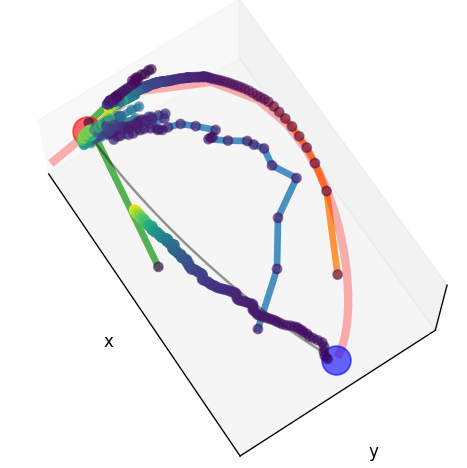

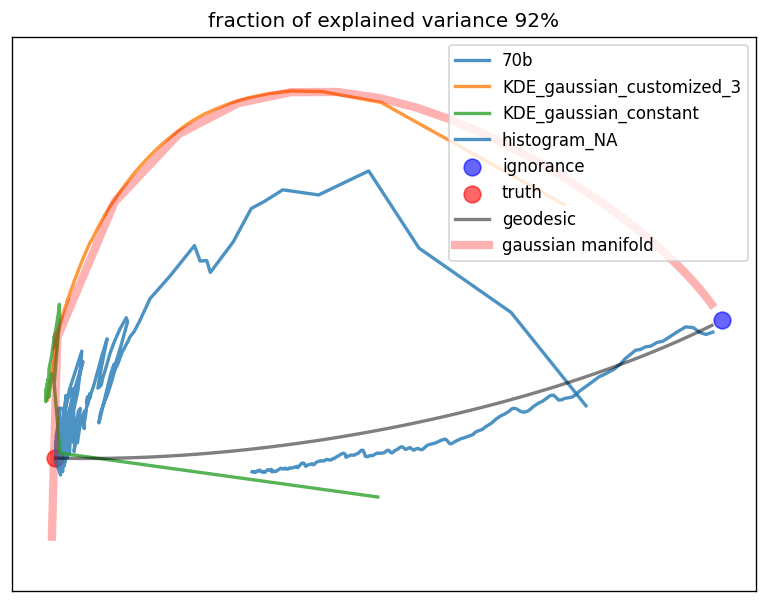

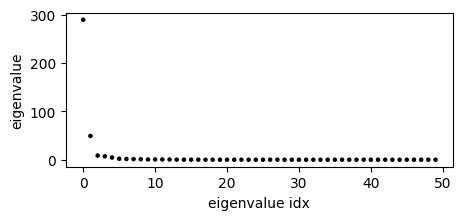

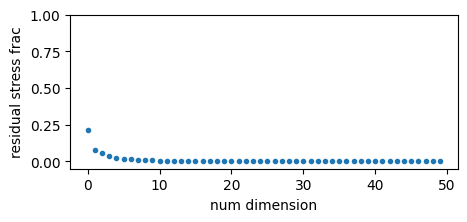

In [193]:
sigma, U = np.linalg.eigh(XXT_Hel)
# Reorder sigma and U based on the absolute value of sigma in decreasing order
idx = np.argsort(np.abs(sigma))[::-1]
sigma = sigma[idx]
U = U[:, idx]
U_rescaled = U * np.sqrt(np.abs(sigma))
# U_rescaled = U * sigma

%matplotlib inline 
# Plot with color based on the sign of sigma
spectrum_cutoff = 50
colors = ['black' if value > 0 else 'red' for value in sigma[:spectrum_cutoff]]
plt.figure(figsize=(5,2), dpi=100)
plt.scatter(range(spectrum_cutoff), np.abs(sigma[:spectrum_cutoff]), c=colors, s = 5)
plt.xlabel('eigenvalue idx')
plt.ylabel('eigenvalue')
# plt.yscale("log")

total_var = np.sum(np.abs(sigma))
explained_var = np.cumsum(np.abs(sigma))
plt.figure(figsize=(5,2), dpi=100)
plt.plot(1-explained_var[:50]/total_var, marker = '.', lw =0)
# plt.ylim(0,1.1)
# plt.yscale('log')
plt.xlabel('num dimension')
plt.ylabel('residual stress frac')
plt.ylim(-0.05,1)
sigma[:3]

### 3D Embedding

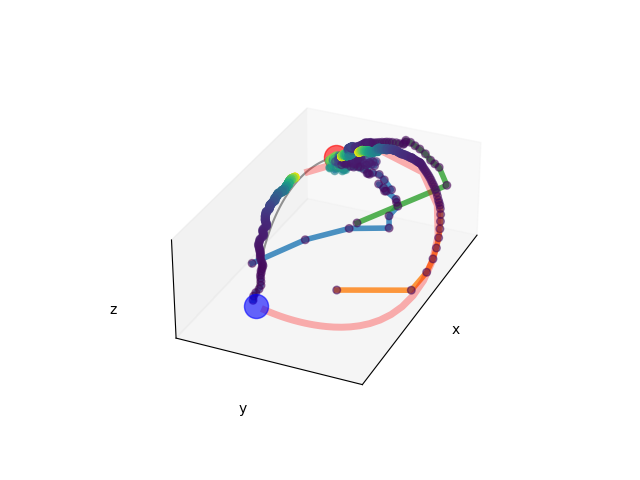

In [194]:
interactive = 1

time_cutoff = -geodesic_steps
interval = 1
geodesic = True
shadows = 0
shadow_alpha = 0.05

num_geodesics = len(PDF_geodesic_list_multi_traj)
num_trajs = len(PDF_list_multi_traj)

submanifold = gaussian_manifold or temperature_manifold

filenames = []

def plotter_with_initial_angle(angle, save_path = None):

    if interactive:
        #interactive 3D plot
        %matplotlib widget 
        fig = plt.figure(dpi = 100)
    else:    
    # static 3D plot
        %matplotlib inline 
        fig = plt.figure(dpi = 100, figsize=(8,8))
        
    ax = fig.add_subplot(111, projection='3d')

    for i in range(num_trajs):
        # learning trajectories
        ax.scatter3D(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], c=range(int(traj_len/interval)), s = 30, alpha = 0.5)
        ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], alpha = 0.8, lw = 4, c = color_list[i])

    # ignorance is the shared
    ign_index = num_trajs * traj_len
    ax.scatter3D(U_rescaled[ign_index,0], U_rescaled[ign_index,1], U_rescaled[ign_index,2], c='blue', s = 300, alpha = 0.6)

    for i in range(num_geodesics-submanifold):
        # geodesics
        start = ign_index+i*(geodesic_steps-1)+1
        end = ign_index+(i+1)*(geodesic_steps-1)+1
        ax.scatter3D(U_rescaled[end-1,0], U_rescaled[end-1,1], U_rescaled[end-1,2], c='red', s = 300, alpha = 0.6)
        if geodesic:
            ax.plot(U_rescaled[start : end,0], 
                    U_rescaled[start : end,1],
                    U_rescaled[start : end,2], c='black', alpha = 0.4)

    if gaussian_manifold:
        # gaussian manifold
        start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
        end = ign_index+num_geodesics*(geodesic_steps-1)+1
        ax.plot(U_rescaled[start : end,0], U_rescaled[start : end,1], U_rescaled[start : end,2], c='red', alpha = 0.3, lw = 5, label = "gaussian manifold")

    if temperature_manifold:
        # gaussian manifold
        start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
        end = ign_index+num_geodesics*(geodesic_steps-1)+1
        ax.plot(U_rescaled[start : end,0], U_rescaled[start : end,1], U_rescaled[start : end,2], c='red', alpha = 0.3, lw = 5, label = "temperature manifold")


    # if not interactive:
    #     ax.legend()
            
            
    x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
    y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
    z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    if shadows:
        for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):        
            for i in range(len(PDF_list_multi_traj)):
                ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[0]], U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[1]], c=range(int(traj_len/interval)), alpha = shadow_alpha, zs=zs, zdir=zdir)

        
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(elev=30, azim=angle)
    # plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
    # plt.axis('equal')
    ax.set_aspect('equal')
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        filenames.append(save_path)
        plt.close(fig)  # Save the plot without displaying it
    
    
plotter_with_initial_angle(angle = 24)    

### Animate

In [37]:
filenames = []
num_frames = 300
for frame_idx in range(num_frames):
    angle = 2 * 360 * (frame_idx/num_frames)
    save_path = f"../figures/animation/{frame_idx}.png"
    plotter_with_initial_angle(angle = angle, save_path = save_path)    

In [38]:
# Create a GIF using snapshot made
import imageio.v2 as imageio
remark = name.split("/")[-1]
with imageio.get_writer(f'../figures/{remark}.gif', mode='I', duration=30000 / num_frames, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        os.remove(filename)

### 2D Embedding


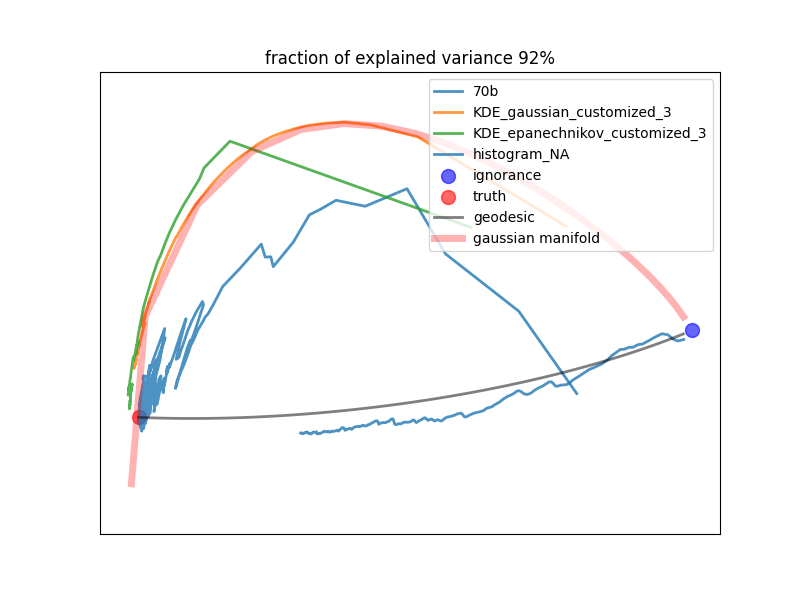

In [195]:
dim1 = 0
dim2 = 1
fig = plt.figure(dpi = 100, figsize=(8,6))
ax = fig.add_subplot(111)
for i in range(len(PDF_list_multi_traj)):    
    # ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], c=range(int(traj_len/interval)), alpha = 0.5)
    ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], alpha = 0.8, lw=2, label = traj_names[i], c = color_list[i])

# ignorance is shared
ign_index = num_trajs * traj_len
ax.scatter(U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2], c='blue', s = 100, alpha = 0.6)
# ax.annotate('ignorance', (U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2]),textcoords="offset points", xytext=(10,10), ha='center')

for i in range(num_geodesics-submanifold):
    # geodesics
    start = ign_index+i*(geodesic_steps-1)+1
    end = ign_index+(i+1)*(geodesic_steps-1)+1
    ax.scatter(U_rescaled[end-1,dim1], U_rescaled[end-1,dim2], c='red', s = 100, alpha = 0.6)
    if geodesic:
        ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='black', alpha=0.5, lw=2)


ax.scatter([],[], c='blue', s = 100, alpha = 0.6, label = 'ignorance')
ax.scatter([],[], c='red', s = 100, alpha = 0.6, label = 'truth')
if geodesic:
    ax.plot([], c='black', alpha=0.5, lw=2, label = 'geodesic')  # Increased line width to thicken the line
# ax.scatter([],[], c='purple', alpha = 0.5, label = "LLM prediction")
  
if submanifold:
    label = "temperature manifold" if temperature_manifold else "gaussian manifold"
    start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
    end = ign_index+num_geodesics*(geodesic_steps-1)+1
    ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='red', alpha = 0.3, lw = 5, label = label)

plt.xticks([])  # Turn off x-axis ticks
plt.yticks([])  # Turn off y-axis ticks
plt.legend(loc = 'best')

# remove repeated labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.title(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
plt.axis('equal');
save_path = f"{name}_Hellinger_2D.png"
plt.savefig(save_path)

### 1D Embedding: Hellinger distance to truth


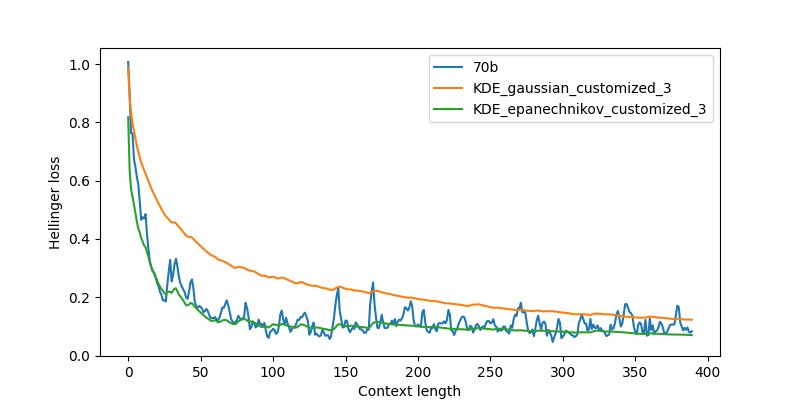

In [196]:
loss_curve_list = []
num_traj_list = [0,1,2,3,4,5,6,7]
num_traj_list = [0,1,2,3,4]
num_traj_list = [0,1,2]
for num_traj in num_traj_list:
    loss_curve = D_Hel[num_traj * traj_len : (num_traj+1) * traj_len, num_trajs * traj_len + geodesic_steps-1]
    loss_curve_list += [loss_curve]

fig = plt.figure(dpi = 100, figsize=(8,4))
ax = fig.add_subplot(111)
for i, loss_curve in enumerate(loss_curve_list):
    ax.plot(loss_curve, label = traj_names[i], c = color_list[i])
plt.legend()    

plt.ylabel("Hellinger loss")
plt.xlabel("Context length")
save_path = f"{name}_Hellinger_1D.png"
plt.savefig(save_path)
# plt.xscale('log')
# plt.yscale('log')

plt.show()



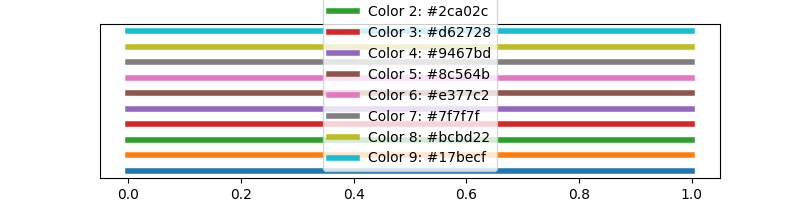

Color 0: #1f77b4
Color 1: #ff7f0e
Color 2: #2ca02c
Color 3: #d62728
Color 4: #9467bd
Color 5: #8c564b
Color 6: #e377c2
Color 7: #7f7f7f
Color 8: #bcbd22
Color 9: #17becf


In [151]:
import matplotlib.pyplot as plt

# Get the default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot lines with each color in the default color cycle
plt.figure(figsize=(8, 2))
for i, color in enumerate(default_colors):
    plt.plot([0, 1], [i, i], label=f'Color {i}: {color}', color=color, linewidth=4)

plt.legend()
plt.yticks([])
plt.show()

# Print the color codes
for i, color in enumerate(default_colors):
    print(f'Color {i}: {color}')

### Bhattacharyya Embedding

In [43]:
# sigma, U = np.linalg.eigh(XXT_BT)
# # Reorder sigma and U based on the absolute value of sigma in decreasing order
# idx = np.argsort(np.abs(sigma))[::-1]
# sigma = sigma[idx]
# U = U[:, idx]

# # U_rescaled = U * sigma
# # Plot with color based on the sign of sigma
# cutoff = 200
# colors = ['black' if value > 0 else 'red' for value in sigma[:cutoff]]
# plt.figure(figsize=(5,2), dpi=150)
# plt.scatter(range(cutoff), np.abs(sigma[:cutoff]), c=colors, s = 5)
# plt.xlabel('eigenvalue idx')
# plt.ylabel('eigenvalue')
# plt.yscale("log")

# total_var = np.sum(np.abs(sigma))
# explained_var = np.cumsum(np.abs(sigma))
# plt.figure(figsize=(5,2), dpi=150)
# plt.plot(1-explained_var[:50]/total_var, marker = '.', lw =0)
# # plt.ylim(0,1.1)
# # plt.yscale('log')
# plt.xlabel('num dimension')
# plt.ylabel('unexplained stress fraction')

In [44]:
# time_cutoff = 300
# interval = 10
# %matplotlib inline 
# save_path = f"../figures/{file.stem}_BT_2D.png"
# fig = plt.figure(dpi = 100, figsize=(8,4))

# dim1 = 0
# dim2 = 1

# plt.scatter(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], c=range(int(time_cutoff/interval)), alpha = 0.6)
# plt.plot(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], alpha = 0.2, label ="learning traj")

# plt.plot(U_rescaled[-geodesic_steps:,dim1], U_rescaled[-geodesic_steps:,dim2], alpha = 0.5, c='black', label ="geodesic")
# plt.scatter(U_rescaled[-1,dim1], U_rescaled[-1,dim2], c='red', s = 100, label ="truth", alpha = 0.6)
# plt.scatter(U_rescaled[-geodesic_steps,dim1], U_rescaled[-geodesic_steps,dim2], c='blue', s = 100, label ="ignorance", alpha = 0.6)

# plt.xticks([])  # Turn off x-axis ticks
# plt.yticks([])  # Turn off y-axis ticks
# plt.title(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
# plt.legend()
# plt.axis('equal');
# plt.savefig(save_path)



In [45]:
# time_cutoff = 120
# interval = 2

# interactive = 1
# shadows = 1
# shadow_alpha = 0.05
# if interactive:
#     #interactive 3D plot
#     %matplotlib widget 
#     fig = plt.figure(dpi = 100)
# else:    
# # static 3D plot
#     %matplotlib inline 
#     fig = plt.figure(dpi = 100, figsize=(8,8))
    
# save_path = f"../figures/{file.stem}_BT_3D.png"
# ax = fig.add_subplot(111, projection='3d')

# # invert x axis
# # U_rescaled[:,0] = -U_rescaled[:,0]
# ax.scatter3D(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1], U_rescaled[:time_cutoff:interval,2], c=range(int(time_cutoff/interval)), s = 30, alpha = 0.8)
# ax.scatter3D(U_rescaled[-geodesic_steps,0], U_rescaled[-geodesic_steps,1], U_rescaled[-geodesic_steps,2], c='blue', s = 100, label ="ignorance", alpha = 0.6)
# ax.scatter3D(U_rescaled[-1,0], U_rescaled[-1,1], U_rescaled[-1,2], c='red', s = 100, label ="truth", alpha = 0.6)
# ax.plot(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1],U_rescaled[:time_cutoff:interval,2], alpha = 0.4, label ="learning traj")
# ax.plot(U_rescaled[-geodesic_steps:,0], U_rescaled[-geodesic_steps:,1],U_rescaled[-geodesic_steps:,2], c='black', alpha = 0.4, label ="geodesic")
# ax.legend()


# x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
# y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
# z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

# if shadows:
#     # 2D projections
#     for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):
#         ax.plot(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = 'gray', alpha = shadow_alpha, zs=zs)
#         ax.scatter(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = range(int(time_cutoff/interval)), alpha = shadow_alpha, zs=zs)
        
#         ax.plot(U_rescaled[-geodesic_steps,idx_tuple[0]], U_rescaled[-geodesic_steps,idx_tuple[1]], zdir=zdir, c = 'blue', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
#         ax.plot(U_rescaled[-1,idx_tuple[0]], U_rescaled[-1,idx_tuple[1]], zdir=zdir, c = 'red', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
#         ax.plot(U_rescaled[-geodesic_steps:,idx_tuple[0]], U_rescaled[-geodesic_steps:,idx_tuple[1]], zdir=zdir, c = 'black', alpha = shadow_alpha, zs=zs)
        
    
# ax.set_xticks([]) 
# ax.set_yticks([]) 
# ax.set_zticks([])

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
# # plt.axis('equal')
# ax.set_aspect('equal')
# if not interactive:
#     plt.savefig(save_path)
# plt.show()